In [2]:
FOLDER_TEST = "exame-pulmao"
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-HCPA-tf12-all/" + FOLDER_TEST
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/output-2d/HMV-HCPA-tf12-all/" + FOLDER_TEST

SUB_FILE = ['axis1', 'axis2']
# SUB_FILE = ['axis1']


EPOCHS = 10
IMG_HEIGHT = 448
IMG_WIDTH = 448
IMG_CHANNELS = 3
SELECTED_MODEL = ''
NUM_CLASSES = 2
DATA_FOLDER = '20201217-2/'
LOG_FOLDER = 'logs/' + DATA_FOLDER
TRAINING_FOLDER = 'training/' + DATA_FOLDER
MODEL_FOLDER = 'models/' + DATA_FOLDER
IMAGE_FOLDER = 'images/' + DATA_FOLDER

STRUCTURE_DATASET_FOLDER = "csv/input/"+DATA_FOLDER
OUTPUT_PREDICTED_FOLDER = "csv/output/" + DATA_FOLDER


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf
import utilities.plot_metrics as pm

Check if there is available GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def get_file_path(folder, search_filter=''):
    '''
    Get all files (full path) contained in a PATH folder by specified search filter 
    '''
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(fold_number, cur_subfile, data_train, data_test):
    ''' Creates and returns a dataframe with all the full paths (for slice) for train and test images. 
    Save it as log. 
    '''
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row['covid']

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row['covid']
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))
#     print(dfs)
    train_df, validation_df = dfs[0], dfs[1]


    if not os.path.exists("logs/"): 
        os.mkdir("logs/")
    if not os.path.exists(LOG_FOLDER): 
        os.mkdir(LOG_FOLDER)
        
    train_df.to_csv("{}/train{}.csv".format(LOG_FOLDER, fold_number), index=False)
    validation_df.to_csv("{}/test{}.csv".format(LOG_FOLDER, fold_number), index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [5]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [6]:
#show_gallery("all")

In [7]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

In [8]:
def get_base_model():
    base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    return base_model

In [9]:

def get_model_resnet101():
    with tf.device('/GPU:0'):
        conv_base = get_base_model()
        conv_base.trainable = True
        
#         set_trainable = False
#         for layer in conv_base.layers:
#             if layer.name == 'block1_conv1':
#                 set_trainable = True
#             if set_trainable:
#                 layer.trainable = True
#             else:
#                 layer.trainable = False

        x = conv_base.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        '''Added'''
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
        x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        preds = tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'softmax')(x)
        
        model = tf.keras.Model(inputs=conv_base.input, outputs=preds)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
                      loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'resnet101')

In [10]:
def train_model(model, train_df, validation_df, epochs, fold, axis):
    batch_size = 8
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    print(train_generator.class_indices)
    print(validation_generator.class_indices)
    
    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
        
    # callbacks, save each time
    # training/20200827/vgg16/fold4/axis2
    checkpoint_path = "training/"
    if not os.path.exists("training/"): 
        os.mkdir("training/")
    checkpoint_path = "{}/".format(TRAINING_FOLDER)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/fold{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
    
    checkpoint_path = "{}/{}/fold{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    # Save dict results of history and legend from current model
    # models/20200827/vgg16/fold4/axis2/{history|legend}
    if not os.path.exists("models/"): 
        os.mkdir("models/")
    
    model_dir = "{}/".format(MODEL_FOLDER)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}".format(MODEL_FOLDER, SELECTED_MODEL)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}/fold{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    model_dir = "{}/{}/fold{}/{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
#     checkpoint_path = checkpoint_path + "/cp-{epoch:04d}.ckpt"
    checkpoint_path = checkpoint_path +"/my_checkpoint"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 25 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=cp_callback
                       )
    
    # Save last values
#     model.save_weights(checkpoint_dir+"/my_checkpoint")
    # model.save(checkpoint_dir+"/my_checkpoint")
    
    # Save history
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = model_dir + 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Save classes
    print(train_generator.class_indices)
    np.save(model_dir + 'legend', train_generator.class_indices)
    return history.history

In [11]:

def plot_results(history, sub_folder, fold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    
    image_dir = "images/"
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/".format(IMAGE_FOLDER)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig(image_dir + 'accuracy', pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig(image_dir + 'loss', orientation='portrait', pad_inches=0.1)

    plt.show()

Function to evaluate model for data folders (patients).

In [12]:
def predictions_by_patient(model, patients, legend_file, axis):
    results = []
    for p in patients:
        # for axis in SUB_FILE:
        curr_dir = "{}/{}/{}".format(VALIDATION_IMG_SRC_FOLDER, p, axis)
        imgs_filename = sorted(os.listdir(curr_dir))
        test_filenames = imgs_filename[:]
        test_df = pd.DataFrame({
                'filename': test_filenames
            })
        nb_samples = test_df.shape[0]

        test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(IMG_WIDTH, IMG_HEIGHT),
                batch_size=16,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))

        test_df['predicted'] = [np.where(pr == np.max(pr))[0][0] for pr in predict]
        test_df['patient'] = p
        test_df['axis'] = axis
        results.append(test_df)

    print('Axis: ', test_df['axis'][0])
    df_result = pd.DataFrame(columns=['predicted', 'patient','count'])
    for i,test_df in enumerate(results):
        cur_patient = test_df['patient'][0]
        if os.path.isfile(legend_file+'.npy'):
            class_indices = np.load(legend_file+'.npy', allow_pickle=True).item()
            class_indices = dict((v,k) for k,v in class_indices.items())
            test_df['predicted'] = test_df['predicted'].replace(class_indices)
        test_df['count'] = 1
        test_df = test_df.groupby('predicted', as_index = False)['count'].count()
        test_df['patient'] = cur_patient
        df_result = df_result.append(test_df)
    return df_result
        
    

Call the model for 'axis1...n' and folds [ 1...N ]

In [ ]:
data_train = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, 1))
labels = data_train['covid'].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))

for axis in SUB_FILE:
    
    ''' CREATE PATHS FOR SAVE OUTPUT '''
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    ''''''
    
    ''' CREATE DATAFRAME AND CONFUSION MATRIX - ACCUMULATED '''
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted', 'count'])
    # Generate confusion matrix
    confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)
    ''''''
    
    for n_fold in [5]:
#     for n_fold in [j+1 for j in range(5)]:
        print("\n\n\nFold", str(n_fold))
        
        data_train = pd.read_csv("{}/train/train{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        train_df, validation_df = get_data_set(n_fold, axis, data_train, data_validation)
        data_validation_dict = dict(zip(data_validation.nome, data_validation.covid))
        
        print('\n'+axis+'\n=====')
        model, SELECTED_MODEL = get_model_resnet101()
        history = train_model(model, train_df, validation_df, EPOCHS, n_fold, axis)
        
        #Plot Results
        plot_results(history, axis, n_fold, SELECTED_MODEL)
        # Load legend
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        

## Check models!
Load saved model


axis1



Fold 1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 454, 454, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 224, 224, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 224, 224, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image fil

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image fi

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image fil

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image fil

Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 164 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image filenames.
Found 82 validated image fi

<Figure size 720x216 with 0 Axes>

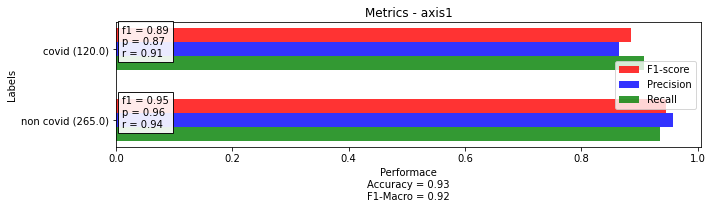

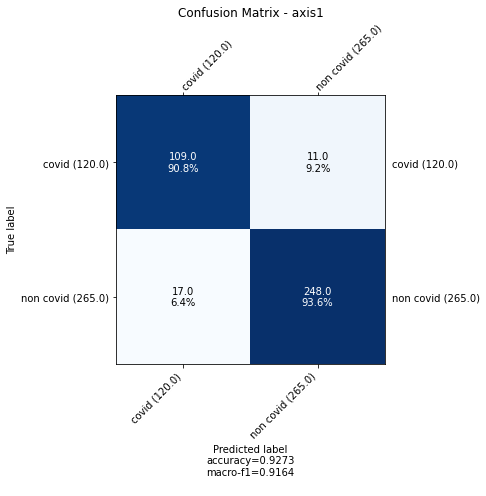

In [13]:
'''
HMV + HCPA
'''
data_train = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, 1))
labels = data_train['covid'].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))


for axis in SUB_FILE:
    print('\n'+axis+'\n=======================================================================================')
    
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    
    
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted', 'count'])
    
    # Generate confusion matrix
    confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)

#     for n_fold in [1, 2, 3]: 
    for n_fold in [j+1 for j in range(5)]:
        print("\n\n\nFold", str(n_fold))
        
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        
        data_validation_dict = dict(zip(data_validation.nome, data_validation.covid))
        
        model, SELECTED_MODEL = get_model_resnet101()
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        
        model = tf.keras.models.load_model("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, n_fold, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        df = df[idx]
        df.reset_index(drop=True, inplace=True)
        df['fold'] = n_fold
        df['real'] = ''
        last_patient = ''
        
        for index, row in df.iterrows():
            if row['patient'] != last_patient:
                df.loc[index, 'real'] = data_validation_dict[row['patient']]
                real_label_pos = labels_pos_dict[data_validation_dict[row['patient']]]
                pred_label_pos = labels_pos_dict[row['predicted']]
                confusion_matrix[real_label_pos][pred_label_pos] += 1
            last_patient = row['patient']        
        df_axis = df_axis.append(df)
        del model
        
    predicted_dir = "{}/{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis, SELECTED_MODEL)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    df_axis.to_csv(predicted_dir+'predicted.csv', index=False)
    print(labels_pos_dict)
    print(confusion_matrix)
    
    '''
    PRINT METRICS AND CONFUSION MATRIX
    '''
    pm.plot_labels_metrics(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title='Metrics - ' + axis,
                clear_diagonal=False,
                figsize=(15, 105),
                output_file="metrics.png"
            )
    pm.plot_confusion_matrix(
                cm=confusion_matrix,
                normalize=False,
                labels=labels,
                show_zero=False,
                title="Confusion Matrix - " + axis,
                clear_diagonal=False,
                output_file="matrix.png",
                figsize=(10, 7)
#                 verbose=args.verbose,
            )

In [ ]:
''' #########################################################
TEST 6
''' #######################################################

data_train = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, 1))
labels = data_train['covid'].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))


for axis in SUB_FILE:
    print('\n'+axis+'\n=======================================================================================')
    
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    
    
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted', 'count'])
    
#     for n_fold in [1, 2, 3, 4, 5]: 
    for n_fold in [j+1 for j in range(5)]:
        
        # Generate confusion matrix
        confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)

        
        print("\n\n\nFold", str(n_fold))
        
        data_validation = pd.read_csv("{}/test/test{}.csv".format(STRUCTURE_DATASET_FOLDER, 7))
        
        data_validation_dict = dict(zip(data_validation.nome, data_validation.covid))
        
        model, SELECTED_MODEL = get_model_resnet101()
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
        
        model = tf.keras.models.load_model("{}/{}/fold{}/{}/my_checkpoint".format(TRAINING_FOLDER, SELECTED_MODEL, n_fold, axis))
        
        # Test with other patients
        df = predictions_by_patient(model, data_validation['nome'].to_list(), legend_path, axis)
        idx = df.groupby(['patient'])['count'].transform(max) == df['count']
        df = df[idx]
        df.reset_index(drop=True, inplace=True)
        df['fold'] = n_fold
        df['real'] = ''
        last_patient = ''
        
        for index, row in df.iterrows():
            if row['patient'] != last_patient:
                df.loc[index, 'real'] = data_validation_dict[row['patient']]
                real_label_pos = labels_pos_dict[data_validation_dict[row['patient']]]
                pred_label_pos = labels_pos_dict[row['predicted']]
                confusion_matrix[real_label_pos][pred_label_pos] += 1
            last_patient = row['patient']        
        df_axis = df_axis.append(df)
        del model
        
        print(labels_pos_dict)
        print(confusion_matrix)

        '''
        PRINT METRICS AND CONFUSION MATRIX
        '''
        pm.plot_labels_metrics(
                    cm=confusion_matrix,
                    normalize=False,
                    labels=labels,
                    show_zero=False,
                    title='Metrics - ' + axis,
                    clear_diagonal=False,
                    figsize=(15, 105),
                    output_file="metrics.png"
                )
        pm.plot_confusion_matrix(
                    cm=confusion_matrix,
                    normalize=False,
                    labels=labels,
                    show_zero=False,
                    title="Confusion Matrix - " + axis,
                    clear_diagonal=False,
                    output_file="matrix.png",
                    figsize=(10, 7)
                )
    predicted_dir = "{}/{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis, SELECTED_MODEL)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    df_axis.to_csv(predicted_dir+'predicted_test7_hcpa.csv', index=False)

In [4]:
for axis in SUB_FILE:
    print('\n'+axis+'\n=====')
    for n_fold in [j+1 for j in range(5)]:
        print("\n\n\nFold", str(n_fold))        
        #model, SELECTED_MODEL = get_model_resnet50()
        SELECTED_MODEL = 'resnet101'
        df = pd.read_csv("{}/{}/fold{}/{}/history.csv".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis))
        print(max(df['val_accuracy']))
        print((df['val_accuracy'].mean()))
#         print(df['val_accuracy'])



axis1
=====



Fold 1
0.8680291771888733
0.8542458891868592



Fold 2
0.935568630695343
0.9115729212760926



Fold 3
0.9307668209075928
0.9071451187133789



Fold 4
0.9005006551742554
0.8692897439002991



Fold 5
0.9281914830207824
0.9033322930335999

axis2
=====



Fold 1
0.8849809765815735
0.856305456161499



Fold 2
0.8919962644577026
0.8662391781806946



Fold 3
0.8783270120620728
0.8697401821613312



Fold 4
0.8760951161384583
0.859105134010315



Fold 5
0.919899880886078
0.9076188981533051
